# Goldratt's Dice Game

*Paul Bayer, 2019-11-22 v2.0*

Goldratt's Dice Game from his business novel "The Goal" is a classical illustration that dependencies and statistical fluctuations diminish the throughput through a system.

Alex Rogo, the hero of the novel plays a game with five boys:

>*While they go get the others, I figure out the details. The system I've set up is intended to "process" matches. It does this by moving a quantity of match sticks out of their box, and through each of the bowls in succession. The dice determine how many matches can be moved from one bowl to the next. The dice represent the capacity of each resource, each bowl; the set of bowls are my dependent events, my stages of production. Each has exactly the same capacity as the others, but its actual yield will fluctuate somewhat.*

>*In order to keep those fluctuations minimal, however, I decide to use only one of the dice. This allows the fluctuations to range from one to six. So from the first bowl, I can move to the next bowls in line any quantity of matches ranging from a minimum of one to a maximum of six.*

>*Throughput in this system is the speed at which matches come out of the last bowl, Inventory consists of the total number of matches in all of the bowls at any time. And I'm going to assume that market demand is exactly equal to the average number of matches that the system can process. Production capacity of each resource and market demand are perfectly in balance. So that means I now have a model of a perfectly balanced manufacturing plant.*

>*Five of the boys decide to play. Besides Dave, there are Andy, Ben, Chuck, and Evan. Each of them sits behind one of the bowls. I find some paper and a pencil to record what happens. Then I explain what they're supposed to do.*

>*"The idea is to move as many matches as you can from your bowl to the bowl on your right. When it's your turn, you roll the die, and the number that comes up is the number of matches you can move. Got it?"*

>*They all nod. "But you can only move as many matches as you've got in your bowl. So if you roll a five and you only have two matches in your bowl, then you can only move two matches. And if it comes to your turn and you don't have any matches, then naturally you can't move any."*

>*Eliyahu M Goldratt: The Goal.– 3rd ed, p. 105*

Then Rogo explains to the boys that with the die on average they should pass `3.5` matches through the system, so after twenty cycles they should have got an output of seventy.

![The Dice Game](../src/images/DiceGame.png)

## An assembly line

As Goldratt described it, the game is done in a fixed cycle – no asynchronism here and no need for a discrete-event-simulation. But more realistically it could be seen as an assembly line with buffers between the five workers. The workers take on average 3.5 time units for processing an item and they are admonished to work as fast as possible. 

We need some data structure for workers …

In [1]:
using Simulate, Distributions, DataFrames, Random

mutable struct Worker
    nr::Int64              # worker number
    input::Channel  
    output::Channel
    dist::Distribution     # distribution for processing time
    perform::Float64       # worker performance factor
    done::Int64            # number of finished items
end

… and a function representing their operation. The buffers are represented by channels. Then we build a system by creating workers and connecting them by channels. We start the work processes with their respective data and run the simulation.

In [2]:
stats(nr, len) = push!(df, (tau(), nr, len))  ## write buffersize to dataframe

function work(w::Worker)
    job = take!(w.input)
    stats(w.nr, length(w.input.data))
    delay!(rand(w.dist)/w.perform)
    put!(w.output, job)
    stats(w.nr+1, length(w.output.data))
    w.done += 1
end

reset!(𝐶)
Random.seed!(1234)                 # seed random number generator
df = DataFrame(time=Float64[], channel=Int[], length=Int[])

C = [Channel(Inf) for i in 1:6]    # create 6 channels
j = reverse(Array(1:8))
for i in 5:-1:2                    # seed channels 2:5 each with 2 inventory items
    put!(C[i], j[(i-1)*2])
    put!(C[i], j[(i-1)*2-1])
end
for i in 9:1000                    # put other 992 jobs into channel 1
    put!(C[1], i)
end

W = [Worker(i, C[i], C[i+1], Uniform(0.5, 6.5), 1.0, 0) for i in 1:5]
for i in 1:5
    process!(SP(i, work, W[i]))
end
run!(𝐶, 1000)

"run! finished with 1390 clock events, 0 sample steps, simulation time: 1000.0"

In [3]:
length(C[6].data)                    # how much got produced?

272

In [4]:
1000/272

3.676470588235294

After running for 1000 time units, we got 272 finished items in channel 6, meaning an average cycle time of 3.68, not 3.5 as expected. The expected throughput would have been 286 units, so the line produced only 95% of that, even under "perfect" conditions like unlimited supply, an in-process inventory to start with, infinite buffer sizes, a perfectly balanced line and equally performing workers without breaks … What happened?

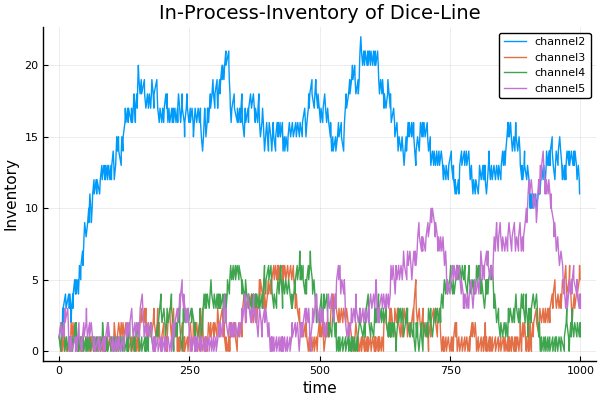

In [6]:
using Plots
pyplot()

function inventory_plot(n::Int64, title)
    for i ∈ 2:n
        d = df[df.channel .== i, :]
        doplot = i == 2 ? plot : plot! 
        doplot(d.time, d.length, label="channel$i")
    end
    title!(title)
    xlabel!("time")
    ylabel!("Inventory")
end
inventory_plot(5, "In-Process-Inventory of Dice-Line")

We see that statistical fluctuations in processing times (the dice!) lead to wildly fluctuating buffers, overproduction of worker 1 (look at channel 2) and also to starvation of other workers down the line when their input buffers are empty. Let's calculate the inventory of unfinished goods in the line at the end of the simulation run:

In [7]:
1000-length(C[1].data)-length(C[6].data)

26

This gives an average of 6.5 inventory items in channels 2-5. But as we see in the plot, some channels are often empty, leading to some starvation.

## Parametrizing the model

For further investigations we parametrize our model. This is not easily done in graphically oriented simulators, but we can do it with `Simulate.jl`.

As parameters we take:

- `n`: the length of the line (number of workers)
- `mw`: max WIP-buffer sizes (WIP is work in progress),
- `vp`: variation in processing times from item to item and,
- `vw`: variation between worker performance,
- `d`: the duration of the simulation run

In [7]:
function dice_line(n, mw, vp, vw; d=1000, seed=1234, jobs=1000)
    reset!(𝐶)
    Random.seed!(seed)                  # seed random number generator
    global df = DataFrame(time=Float64[], channel=Int[], length=Int[])

    global C = [Channel(mw) for i in 1:n+1] # create n+1 channels with given buffer sizes
    C[1] = Channel(Inf)                 # unlimited sizes for channels 1 and n+1
    C[n+1] = Channel(Inf)
    j = reverse(Array(1:(n-1)*2))
    for i in n:-1:2                     # seed channels 2:(n-1) each with 2 inventory items
        C[i].sz_max > 0 ? put!(C[i], j[(i-1)*2]) : nothing
        C[i].sz_max > 1 ? put!(C[i], j[(i-1)*2-1]) : nothing
    end
    for i in ((n-1)*2+1):jobs           # put other jobs into channel 1
        put!(C[1], i)
    end

    wp = rand(vw, n)                    # worker performance
    W = [Worker(i, C[i], C[i+1], vp, wp[i], 0) for i in 1:n]
    for i in 1:n
        process!(SP(i, work, W[i]))
    end
    run!(𝐶, d)
end

dice_line (generic function with 1 method)

## Kanban …

Against too much inventory we have Kanban. So let's introduce maximum buffer sizes of 5 items. We have yet our five perfect workers without varying performance.

In [8]:
using Printf
println(dice_line(5, 5, Uniform(0.5, 6.5), Normal(1,0)))
println(length(C[6].data), " items produced!")
@printf("%5.2f%s capacity utilization", 3.5*length(C[6].data)/10, "%")

run! finished with 1341 clock events, 0 sample steps, simulation time: 1000.0
266 items produced!
93.10% capacity utilization

Uups! We throttled our system further, to an output of 266.

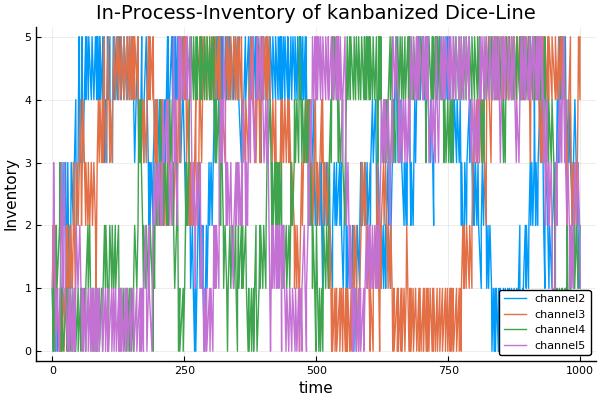

In [9]:
inventory_plot(5, "In-Process-Inventory of kanbanized Dice-Line")

But we got much less inventory in the system. The throttling occurs because with Kanban in-process-inventories get more often to zero. Seemingly Kanban is no solution for our throughput problem but constrains the system further. With Kanban we have reduced unpredictability and instability in inventory. 

Let's pause a moment to look at what we have here: we got a small model with which we can simulate and analyze the impact of dependencies (line length and buffer sizes) and statistical fluctuations (in processing time and worker performance) on simple assembly lines like there are thousands in industry. This is no minor achievement.

## Investigating assembly lines

With the parametrized model we can do some investigations into the behaviour of assembly lines. 

For that we take first some further simplification steps:

1. We normalize the model by assuming a mean processing time of 1. 
2. We choose a gamma distribution as more realistic for processing times than the uniform distribution, we used until now following Goldratt's example:

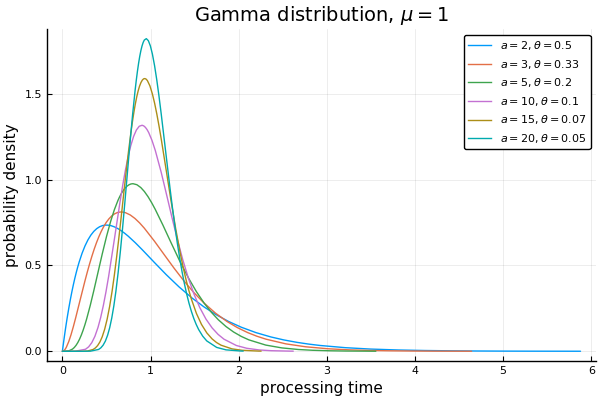

In [10]:
using StatsPlots, LaTeXStrings

for i in [2,3,5,10,15,20]
    doplot = i == 2 ? plot : plot!
    doplot(Gamma(i, 1/i), label=latexstring("a=$i, \\theta=$(round(1/i, digits=2))"))
end
xlabel!("processing time")
ylabel!("probability density")
title!(L"Gamma distribution, $\mu=1$")

In [11]:
println(dice_line(5, 5, Gamma(10,1/10), Normal(1,0)))
println(length(C[6].data), " items produced!")
@printf("y = %5.3f [1/t]", length(C[6].data)/1000)

run! finished with 4847 clock events, 0 sample steps, simulation time: 1000.0
966 items produced!
y = 0.966 [1/t]

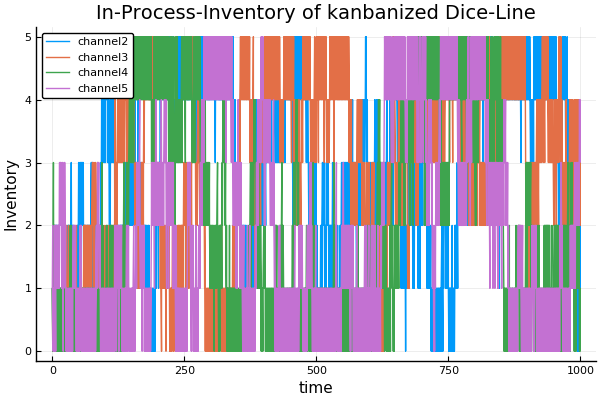

In [12]:
inventory_plot(5, "In-Process-Inventory of kanbanized Dice-Line")

Before we go deeper into parameters, we have to check how much path dependence and statistical fluctuations vary the outcome. Therefore we repeat the simulation 30 times with different random number seeds and analyze the distribution of the outcome. As outcome we choose the throughput rate y [1/t] which is also an indicator for line performance.

μ: 0.966, σ: 0.006, LCL: 0.950, UCL: 0.983


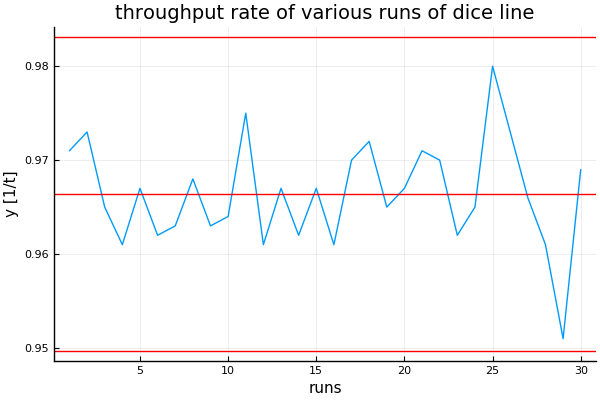

In [13]:
Random.seed!(1234)
s = abs.(rand(Int, 30))
tc = ones(30)
for i = 1:30
    dice_line(5, 5, Gamma(10,1/10), Normal(1,0), seed=s[i], jobs=1200)
    tc[i] = length(C[6].data)/1000
end
ys = (μ=mean(tc), σ=std(tc))
@printf("μ: %5.3f, σ: %5.3f, LCL: %5.3f, UCL: %5.3f\n", ys.μ, ys.σ, ys.μ-3ys.σ, ys.μ+3ys.σ)
plot(1:30, tc, title="throughput rate of various runs of dice line", xlabel="runs", 
    ylabel="y [1/t]", legend=:none)
hline!([ys.μ, ys.μ-3ys.σ, ys.μ+3ys.σ], lc=:red)

## Experimental design

Our response variable y seems to be under statistical control and its fluctuation is of the same order as the effects we are after. But with an experimental design those fluctuations should cancel out. We setup it up with:

- `n`: number of workers, line length,
- `b`: buffersize between workers,
- `a`: shape parameter of gamma distribution of processing times (bigger a means less variation),
- `σ`: standard deviation of performance variation between workers.

In [14]:
using StatsModels, ExperimentalDesign

n=cat(5:10,12:2:20, dims=1)
b=1:10
a=cat(2,3,5:5:20, dims=1)
σ=LinRange(0,0.1,5)

D = FullFactorial((n=n, b=b, a=a, σ=σ), @formula(y ~ n + b + a + σ), explicit = true)
size(D.matrix)

(3300, 4)

We got a design matrix with 3300 rows for 3300 simulations! Let's do something else while the computer works:

In [15]:
y = Float64[]
events = 0
t = @elapsed begin
    for i = 1:3300
        p = Tuple(D.matrix[i, :])
        dice_line(p[1], p[2], Gamma(p[3], 1/p[3]), Normal(1, p[4]), jobs=1200 )
        push!(y, length(C[end].data)/1000)
        global events += 𝐶.evcount
    end
end
@printf("Time elapsed: %5.2f minutes, %d events", t/60, events)

Time elapsed: 73.14 minutes, 33573275 events

It took over 70 minutes on a single process of my 2013 MacBook Pro and over $33\times 10^6$ events.

## Data analysis

We put together a results table and then do some exploratory data analysis:

In [16]:
res = D.matrix 
res.y = y
describe(y)

Summary Stats:
Length:         3300
Missing Count:  0
Mean:           0.892540
Minimum:        0.637000
1st Quartile:   0.863750
Median:         0.904000
3rd Quartile:   0.938000
Maximum:        0.986000
Type:           Float64


The performance of our simulated assembly lines varies between 0.637 and 0.986, which is a huge difference: The worst result is 35.4% below the best one!

In [17]:
vcat(res[y .== maximum(y), :], res[y .== minimum(y), :])

,n,b,a,σ,y
,Real,Real,Real,Real,Float64
1,6,7,20,0.0,0.986
2,5,10,20,0.0,0.986
3,18,1,2,0.05,0.637


The best performance is with the shortest lines, big buffer sizes, small variation in processing times and no variation in performance between workers. But this is just common sense. The worst performance is with a long line, minimum buffers and maximum variation in processing times and in performance between workers. But how big are the effects? 

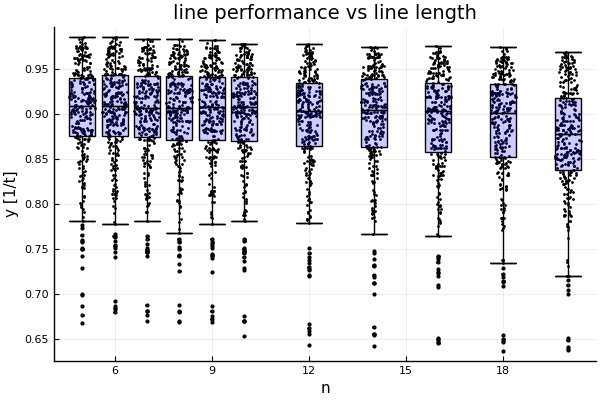

In [18]:
@df res dotplot(:n, :y, title="line performance vs line length", xlabel="n", ylabel="y [1/t]",
    marker=(:circle, 2, 0.3, :none, 1, 0.3, :blue, :solid), legend=:none)
@df res boxplot!(:n, :y, marker=(:none, 0.3, 0.3, :blue, 2, 0.3, :blue, :solid), fill=(0, 0.2, :blue))

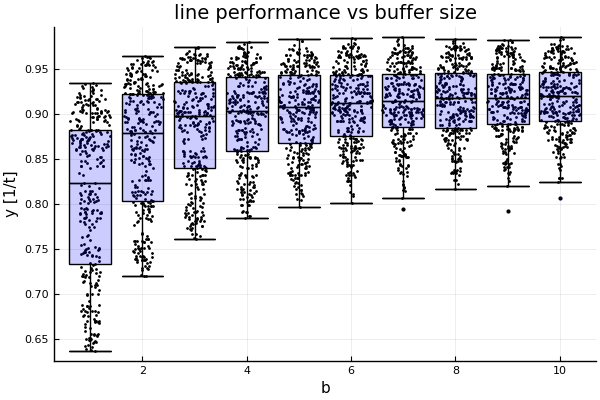

In [19]:
@df res dotplot(:b, :y, title="line performance vs buffer size", xlabel="b", ylabel="y [1/t]",
    marker=(:circle, 2, 0.3, :none, 1, 0.3, :blue, :solid), legend=:none)
@df res boxplot!(:b, :y, marker=(:none, 0.3, 0.3, :blue, 2, 0.3, :blue, :solid), fill=(0, 0.2, :blue))

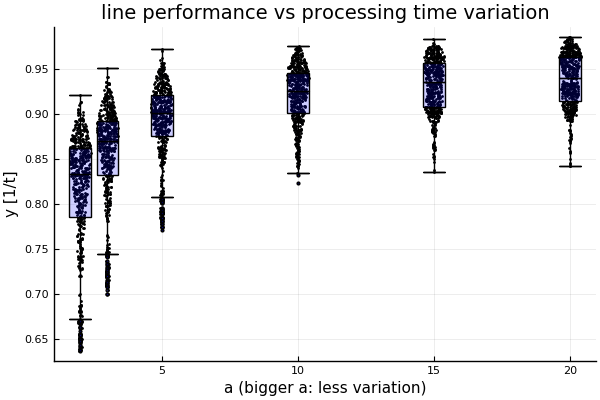

In [20]:
@df res dotplot(:a, :y, title="line performance vs processing time variation", xlabel="a (bigger a: less variation)", 
    ylabel="y [1/t]", marker=(:circle, 2, 0.3, :none, 1, 0.3, :blue, :solid), legend=:none)
@df res boxplot!(:a, :y, marker=(:none, 0.3, 0.3, :blue, 2, 0.3, :blue, :solid), fill=(0, 0.2, :blue))

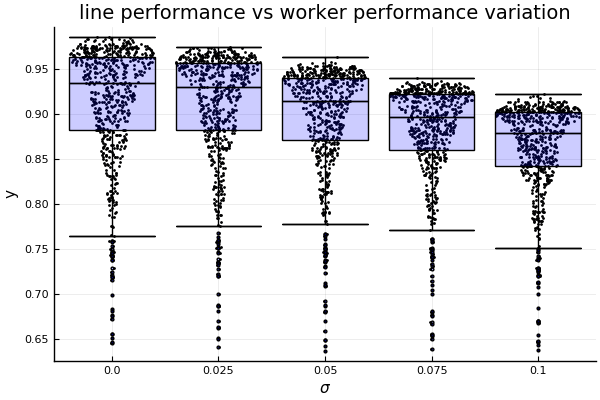

In [21]:
x = Int.(round.(res.σ*40))
@df res dotplot(x, :y, title="line performance vs worker performance variation", xlabel=L"\sigma", ylabel="y",
    marker=(:circle, 2, 0.3, :none, 1, 0.3, :blue, :solid), legend=:none)
@df res boxplot!(x, :y, marker=(:none, 0.3, 0.3, :blue, 2, 0.3, :blue, :solid), fill=(0, 0.2, :blue))
xticks!(collect(0:4), string.(round.(σ, digits=3)))

Buffer sizes and variation in processing time clearly have nonlinear effects while line length and performance variation between workers seem to have more linear ones. Small buffers and variation in processing time constrain the line the most and also are responsible for the worst performances. There seems to be also an interaction between those major two factors.

## Statistical model 

We fit a linear model to the results and account for the nonlinearities with logarithmic terms:

In [22]:
using GLM

ols = lm(@formula(y ~ 1 + n + log(1+b) + log(a) + σ), res)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Array{Float64,1}},GLM.DensePredChol{Float64,LinearAlgebra.Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

y ~ 1 + n + :(log(1 + b)) + :(log(a)) + σ

Coefficients:
───────────────────────────────────────────────────────────────────────────────────
                Estimate   Std. Error   t value  Pr(>|t|)    Lower 95%    Upper 95%
───────────────────────────────────────────────────────────────────────────────────
(Intercept)   0.737767    0.00236236   312.301     <1e-99   0.733135     0.742399  
n            -0.00154808  9.85802e-5   -15.7037    <1e-52  -0.00174136  -0.00135479
log(1 + b)    0.0576485   0.000901501   63.9473    <1e-99   0.055881     0.0594161 
log(a)        0.0510564   0.000566878   90.0659    <1e-99   0.0499449    0.0521679 
σ            -0.512109    0.0134128    -38.1805    <1e-99  -0.538407    -0.485811  
───────────────────────────────────────────────────────────────────────────────────

All parameters are highly significant. We find then - as expected - that the b&a-interaction between buffer size and variation in processing times is highly significant too:

In [23]:
ols2 = lm(@formula(y ~ 1 + n + log(1+b)*log(a) + σ), res)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Array{Float64,1}},GLM.DensePredChol{Float64,LinearAlgebra.Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

y ~ 1 + n + :(log(1 + b)) + :(log(a)) + σ + :(log(1 + b)) & :(log(a))

Coefficients:
───────────────────────────────────────────────────────────────────────────────────────────
                        Estimate   Std. Error   t value  Pr(>|t|)    Lower 95%    Upper 95%
───────────────────────────────────────────────────────────────────────────────────────────
(Intercept)           0.597895    0.00315108   189.743     <1e-99   0.591717     0.604074  
n                    -0.00154808  7.23374e-5   -21.4008    <1e-94  -0.00168991  -0.00140624
log(1 + b)            0.137565    0.00164257    83.7499    <1e-99   0.134344     0.140785  
log(a)                0.124624    0.0014452     86.2334    <1e-99   0.121791     0.127458  
σ                    -0.512109    0.00984225   -52.0317    <1e-99  -0.531407    -0.492812  
log(1 + b

Then we can analyze the effects of the four parameters on line performance:

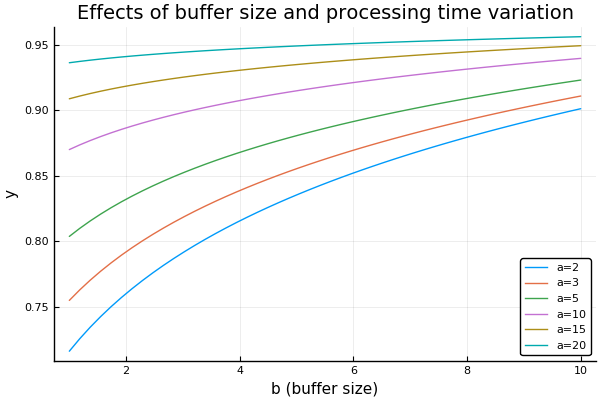

In [24]:
x = LinRange(1,10,50)
for i in a
    _n = fill(mean(n), length(x))
    _a = fill(i, length(x))
    _σ = fill(mean(σ), length(x))
    tmp = DataFrame(n=_n, b=x, a=_a, σ=_σ)
    _y = predict(ols2, tmp)
    doplot = i == 2 ? plot : plot!
    doplot(x, _y, label="a=$i")
end
title!("Effects of buffer size and processing time variation")
xlabel!("b (buffer size)")
ylabel!("y")

Buffer size and processing time variation have nonlinear effects and may account together for 26% line performance losses. This shows how important it is to increase buffer sizes with larger variation in processing times (smaller a). Only with small variation one can reduce buffers without loosing much performance.

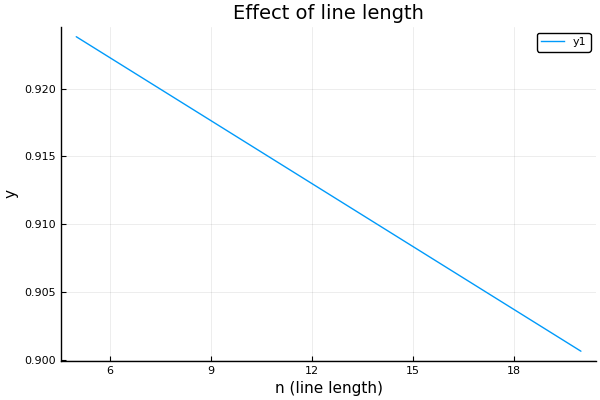

In [25]:
x = LinRange(5, 20, 50)
tmp = DataFrame(n=x, b=fill(mean(b), length(x)), a=fill(mean(a), length(x)), σ=fill(mean(σ), length(x)))
plot(x, predict(ols2, tmp), title="Effect of line length", xlabel="n (line length)", ylabel="y")

This does may account for 3% performance losses.

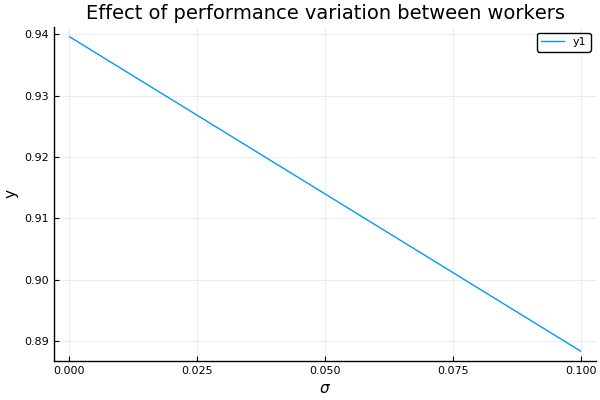

In [26]:
x = LinRange(0,0.1,50)
tmp = DataFrame(n=fill(mean(n), length(x)), b=fill(mean(b), length(x)), a=fill(mean(a), length(x)), σ=x)
plot(x, predict(ols2, tmp), title="Effect of performance variation between workers", xlabel=L"\sigma", ylabel="y")

Variation in performance between workers may diminish line throughput by other 5%.

The four effects combined can account for 34% performance losses from best to worst. This is most of the 35.4% we found above. The rest is statistical fluctuations.

## Final remark

Starting from a simple game and with only a quite small simulation model we could come to conclusions which have a wide applicability for assembly lines. The performance differences in assembly lines are realistic – I have seen them over and over in industry. And we didn't yet account for failures or supply shortfalls. The unawareness of those simple factors costs manufacturing industry billions. 

The most interesting thing to note here, is that from seemingly quite unpredictable behaviour – look at the inventory chart of the beginning – emerge some quite predictable characteristics if we do discrete event simulations with parameter variation and then put the results through some not too sophisticated statistics.

We could not have done those experiments and analyses with real lines as it is possible with simulations on a modern computer with `Julia` and `Simulate.jl`.